<a href="https://colab.research.google.com/github/heidarimohsen92/Signature_Verification/blob/main/Signature_Verification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Tue Nov 15 11:51:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


# Download the `Signature_Verification_Dataset` from kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d robinreni/signature-verification-dataset
!unzip /content/signature-verification-dataset.zip #-d dataset

# Data reading and preparation

In [ ]:
def read_data(dir, data):
    images1 = []  
    images2 = []  
    labels = []

    img_size = 100
    for j in range(0, len(data)):
        path = os.path.join(dir, data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (img_size, img_size))
        img1 = img1.reshape(img_size, img_size, 1)
        images1.append(img1)

        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (img_size, img_size))
        img2 = img2.reshape(img_size, img_size, 1)
        images2.append(img2)

        labels.append(np.array(data.iat[j, 2]))

    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    labels = labels.reshape(-1, 1)
    return images1, images2, labels

In [ ]:
train_dir = '/content/sign_data/sign_data/train/'
train_csv = '/content/sign_data/sign_data/train_data.csv'
test_dir = '/content/sign_data/sign_data/test/'
test_csv = '/content/sign_data/sign_data/test_data.csv'

In [ ]:
df_train = pd.read_csv(train_csv, header=None)
df_train

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
23201,031/02_031.png,031/03_031.png,0
23202,031/02_031.png,031/12_031.png,0
23203,031/02_031.png,031/11_031.png,0
23204,031/02_031.png,031/06_031.png,0


In [ ]:
df_test = pd.read_csv(test_csv, header=None)
df_test

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
5743,066/01_066.png,066/06_066.png,0
5744,066/01_066.png,066/08_066.png,0
5745,066/01_066.png,066/02_066.png,0
5746,066/01_066.png,066/05_066.png,0


# Load Data

In [ ]:
# read data
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
# shuffle
train_images1, train_images2, train_labels = shuffle(train_images1, train_images2, train_labels)
test_images1, test_images2, test_labels = shuffle(test_images1, test_images2, test_labels)

print("train.shape:", train_images1.shape , train_images2.shape , train_labels.shape)
print("test.shape:", test_images1.shape , test_images2.shape , test_labels.shape)

train.shape (23206, 100, 100, 1) (23206, 100, 100, 1) (23206, 1)
test.shape (5748, 100, 100, 1) (5748, 100, 100, 1) (5748, 1)


# Visualize pairs and their labels

In [ ]:
def visualize(images1, images2, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(np.squeeze(tf.concat([images1[i], images2[i]], axis=1)), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(int(labels[i][0]), predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(int(labels[i][0])))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.7, 1.3))
    plt.show()


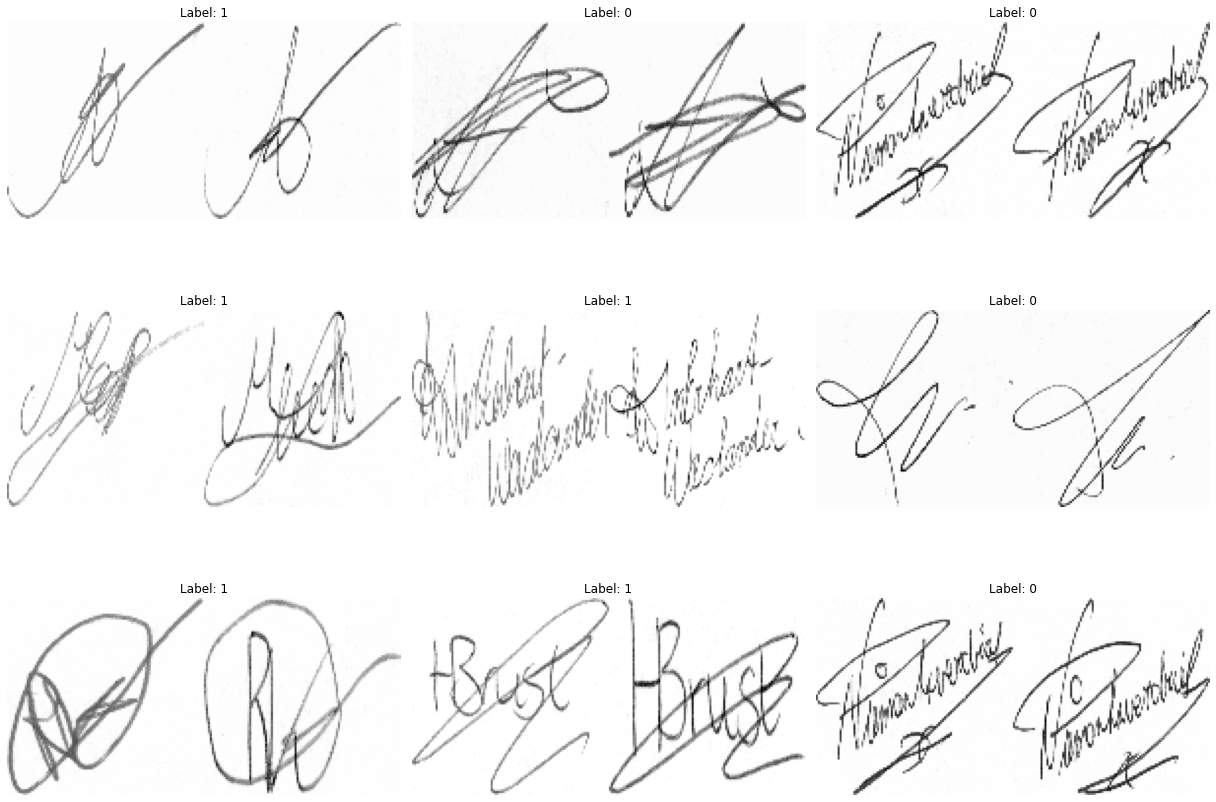

In [ ]:
visualize(train_images1, train_images2, train_labels, to_show=9, num_col=3)

# Euclidean Distance

In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

## **Contrastive Loss**

In [ ]:

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.
      margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).
    """
    # if same pairs == 1
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.
        Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

        """
        # same pairs == 0
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean( (1 - y_true) * square_pred + (y_true) * margin_square )

    return contrastive_loss

## Base Network (signet)

In [ ]:
img_size = 100
def signet(image_shape = (img_size, img_size, 1)):
    # Input
    inputs = Input(image_shape)
    
    conv1 = Conv2D(96, 11, activation='relu', strides=1, padding='same')(inputs)
    bach1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((3,3), strides=2)(bach1)
    
    conv2 = Conv2D(256, 5, activation='relu', strides=1,  padding='same')(pool1)
    bach2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((3,3), strides=2)(bach2)
    drop2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(384, 3, activation='relu', strides=1,  padding='same')(drop2)
    conv3 = Conv2D(256, 3, activation='relu', strides=1,  padding='same')(conv3)
    pool3 = MaxPooling2D((3,3), strides=2)(conv3)
    drop3 = Dropout(0.3)(pool3)

    #flatten 
    # flatt = Flatten()(drop3)
    GAP = GlobalAveragePooling2D()(drop3)
    fc1 = Dense(1024, activation='relu')(GAP)
    drop = Dropout(0.5)(fc1)
    fc = Dense(128, activation='relu')(drop)
    
    return keras.Model(inputs, fc)

tf.keras.backend.clear_session()
# Create The Model
base_network = signet()
base_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 96)      11712     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 49, 49, 256)      1024  

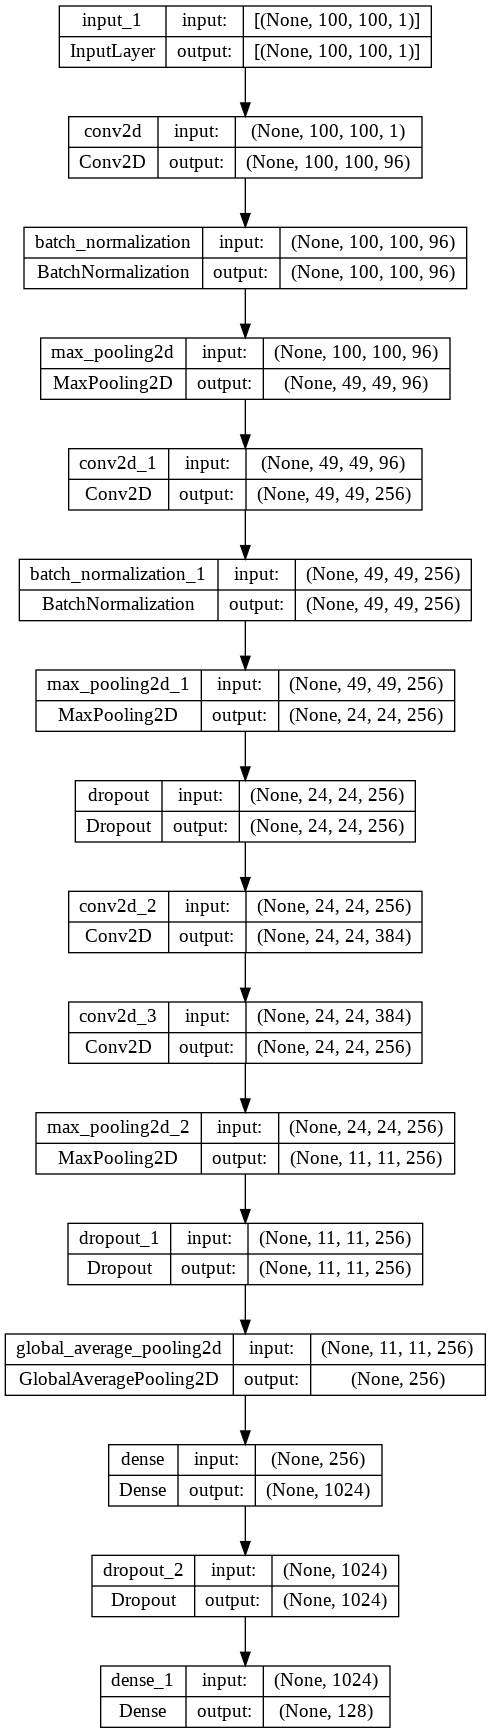

In [ ]:
tf.keras.utils.plot_model(base_network, "signet.png",show_shapes=True)

## Siamese Networks

In [ ]:
img_size = 100
input_shape = (img_size, img_size, 1)
base_network = signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance)([processed_a, processed_b])
output_layer = Dense(1, activation="sigmoid")(distance)

siamese = keras.Model(inputs=[input_a, input_b], outputs=output_layer)
siamese.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 128)          2792256     ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

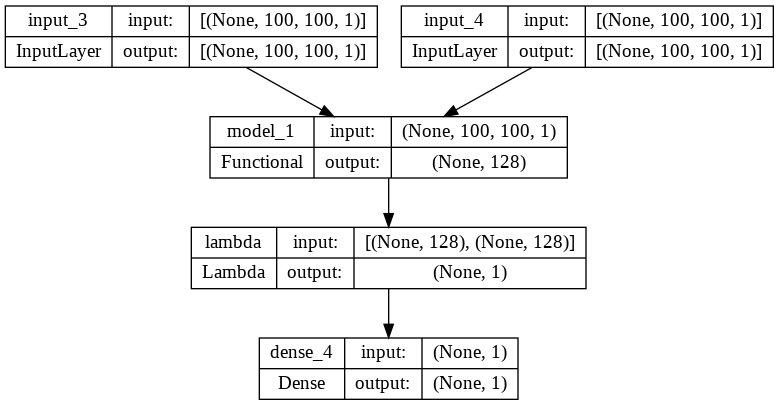

In [ ]:
tf.keras.utils.plot_model(siamese, "siamese.png",show_shapes=True)

# Compile the model with the contrastive loss

In [ ]:
siamese.compile(loss=loss(margin=1), optimizer=RMSprop(learning_rate=1e-4), metrics=["accuracy"])

## Train the model

In [ ]:
callbacks = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('./signet.h5', monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
history = siamese.fit([train_images1, train_images2], train_labels, validation_split=0.30,
                    batch_size=64, verbose=1, epochs=50, callbacks=callbacks)

Epoch 1/50
254/254 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.7043
Epoch 1: val_loss improved from inf to 0.24178, saving model to ./signet.h5
254/254 [==============================] - 102s 346ms/step - loss: 0.2016 - accuracy: 0.7043 - val_loss: 0.2418 - val_accuracy: 0.6241 - lr: 1.0000e-04
Epoch 2/50
254/254 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.8695
Epoch 2: val_loss improved from 0.24178 to 0.16199, saving model to ./signet.h5
254/254 [==============================] - 81s 321ms/step - loss: 0.1684 - accuracy: 0.8695 - val_loss: 0.1620 - val_accuracy: 0.9344 - lr: 1.0000e-04
Epoch 3/50
254/254 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9158
Epoch 3: val_loss did not improve from 0.16199
254/254 [==============================] - 82s 324ms/step - loss: 0.1528 - accuracy: 0.9158 - val_loss: 0.1667 - val_accuracy: 0.9045 - lr: 1.0000e-04
Epoch 4/50
254/254 [==============================] - E

## Visualize results

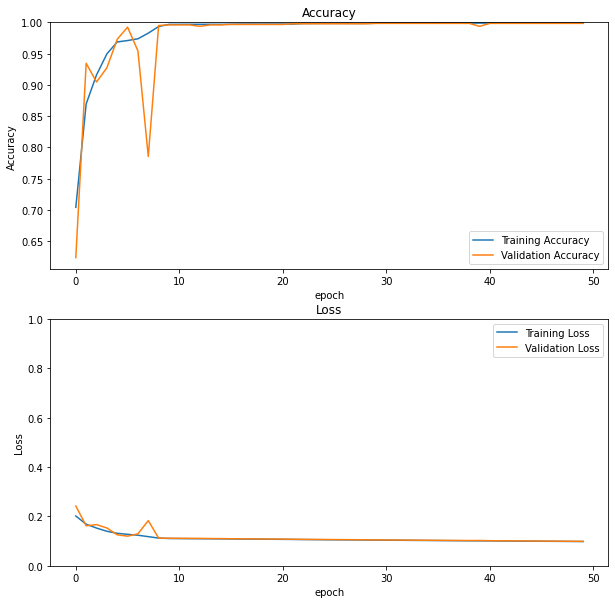

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate the model

In [ ]:
# Predict on training and validation data
siamese.load_weights('/content/signet.h5')

results = siamese.evaluate([test_images1, test_images2], test_labels)
print("test loss, test acc:", results)

180/180 [==============================] - 12s 55ms/step - loss: 0.0882 - accuracy: 0.9958
test loss, test acc: [0.08823494613170624, 0.9958246350288391]


## Visualize the predictions

180/180 [==============================] - 8s 45ms/step


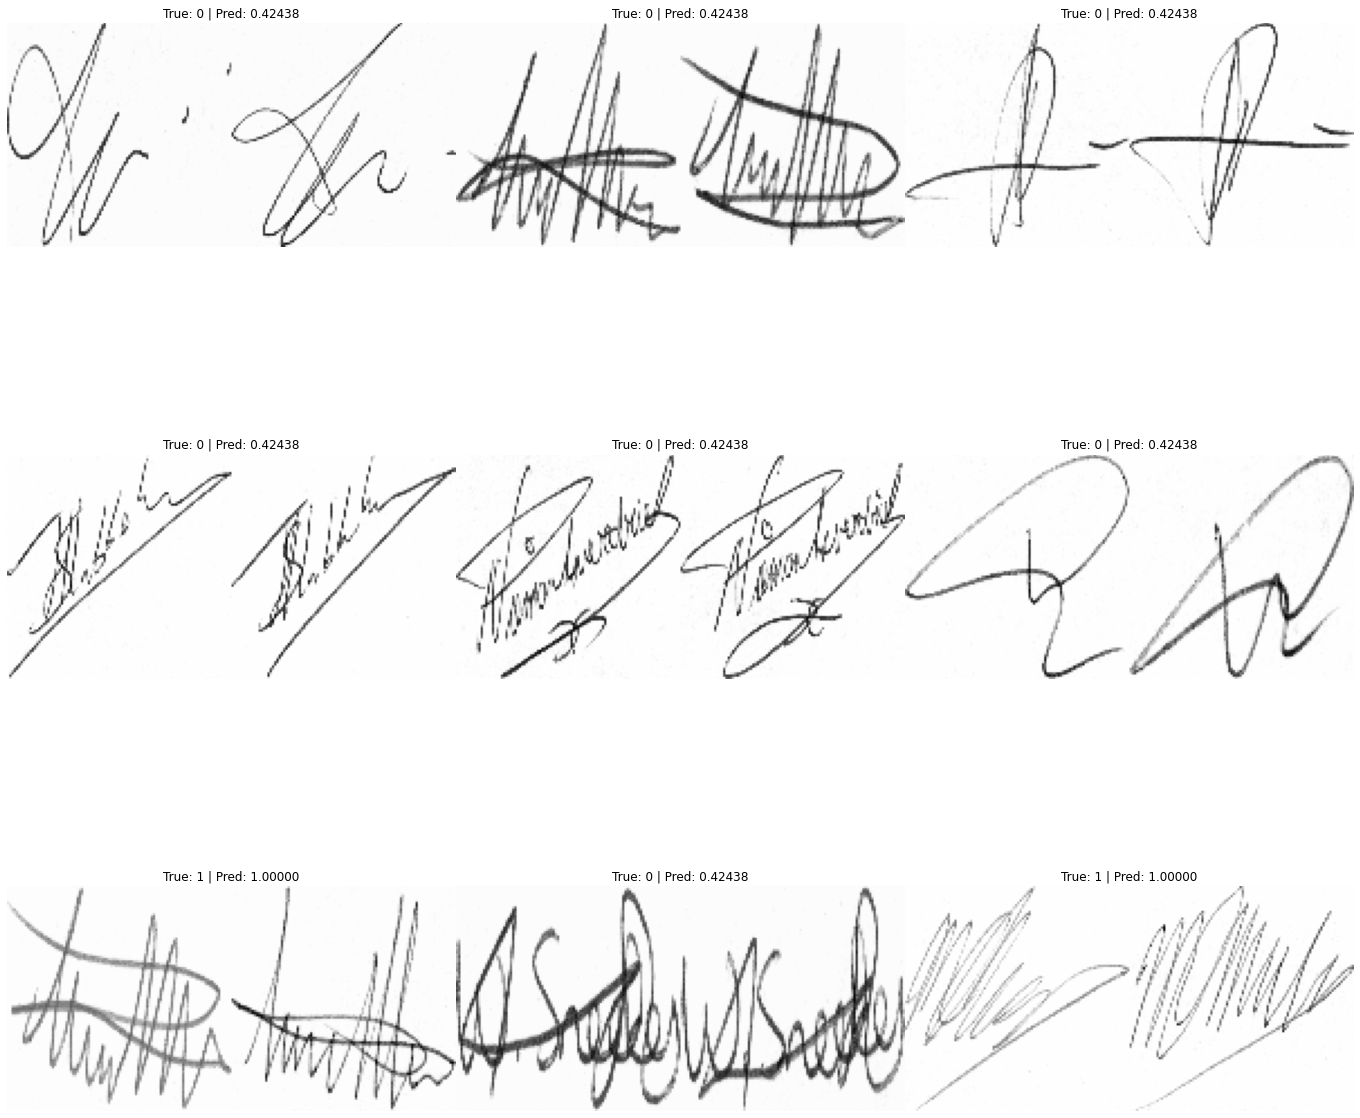

In [ ]:
predictions = siamese.predict([test_images1, test_images2])
visualize(test_images1, test_images2, test_labels, to_show=9, num_col=3, predictions=predictions, test=True)

## Compute ROC accuracy with threshold

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 0)
    ndiff = np.sum(labels == 1)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 0)) / nsame       
        tnr = float(np.sum(labels[idx2] == 1)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
tr_acc, threshold = compute_accuracy_roc(predictions, test_labels)
print('best threshold:', threshold, '  best acc:', tr_acc)

best threshold: 0.42437565326690674   best acc: 0.9959677419354839
